In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import os, shutil
import warnings
warnings.filterwarnings('ignore')

In [2]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d misrakahmed/vegetable-image-dataset
!unzip \*.zip

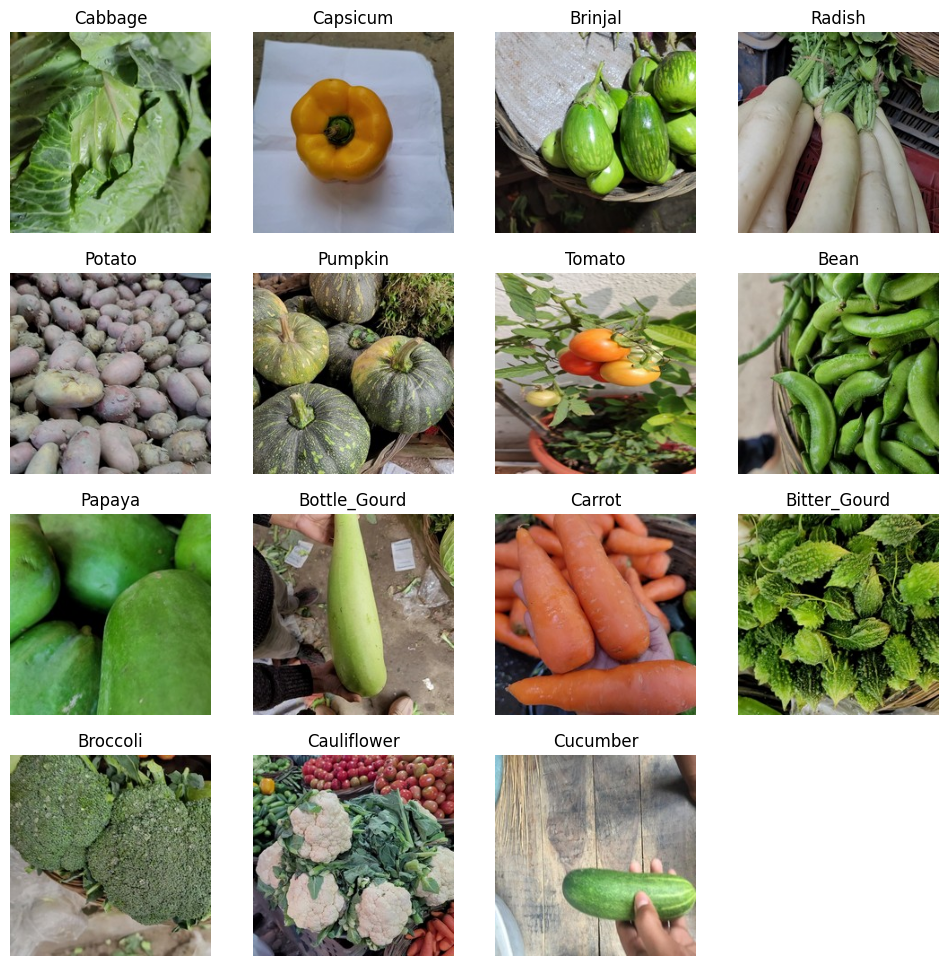

In [4]:
train_path = "../content/Vegetable Images/train"
validation_path = "/content/Vegetable Images/validation"
test_path = "/content/Vegetable Images/test"

image_categories = os.listdir("../content/Vegetable Images/train")
def plot_images(image_categories):

    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):

        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0

        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')

    plt.show()

plot_images(image_categories)

In [5]:
train_gen = ImageDataGenerator(rescale = 1.0/255.0)
train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

val_gen = ImageDataGenerator(rescale = 1.0/255.0)
val_image_generator = train_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

test_gen = ImageDataGenerator(rescale = 1.0/255.0)
test_image_generator = train_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [6]:
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


In [7]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=[150, 150, 3]))
model.add(MaxPooling2D(2, ))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(15, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [8]:
file_path = 'vegetable_classifier.hdf5'
model_checkpoint = ModelCheckpoint(
    filepath=file_path,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [9]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
hist = model.fit(train_image_generator,
                 epochs=2,
                 verbose=1,
                 validation_data=val_image_generator,
                 steps_per_epoch = 15000//32,
                 validation_steps = 3000//32,
                 callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/2
468/468 [==============================] - ETA: 0s - loss: 1.3195 - accuracy: 0.5534
Epoch 1: val_loss improved from inf to 0.55648, saving model to vegetable_classifier.hdf5
468/468 [==============================] - 757s 2s/step - loss: 1.3195 - accuracy: 0.5534 - val_loss: 0.5565 - val_accuracy: 0.8323
Epoch 2/2
468/468 [==============================] - ETA: 0s - loss: 0.5473 - accuracy: 0.8238
Epoch 2: val_loss improved from 0.55648 to 0.31627, saving model to vegetable_classifier.hdf5
468/468 [==============================] - 690s 1s/step - loss: 0.5473 - accuracy: 0.8238 - val_loss: 0.3163 - val_accuracy: 0.9019


In [10]:
model.evaluate(test_image_generator)

94/94 [==============================] - 39s 417ms/step - loss: 0.2906 - accuracy: 0.9107


[0.2906421720981598, 0.9106666445732117]

1/1 [==============================] - 1s 587ms/step


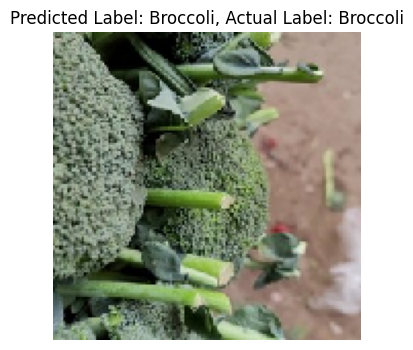

In [12]:
test_image_path = '../content/Vegetable Images/test/Broccoli/1011.jpg'

def generate_predictions(test_image_path, actual_label):

    test_img = image.load_img(test_image_path, target_size=(150, 150))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_vegetable = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_vegetable, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()
generate_predictions(test_image_path, actual_label='Broccoli')